**Задача:**

$\begin{cases}
  \dfrac{dy}{dx} = y, \quad x \in (0, 1],\\
  y(0) = 1.
\end{cases}$

In [1]:
# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Установка устройства для вычислений (CPU или GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


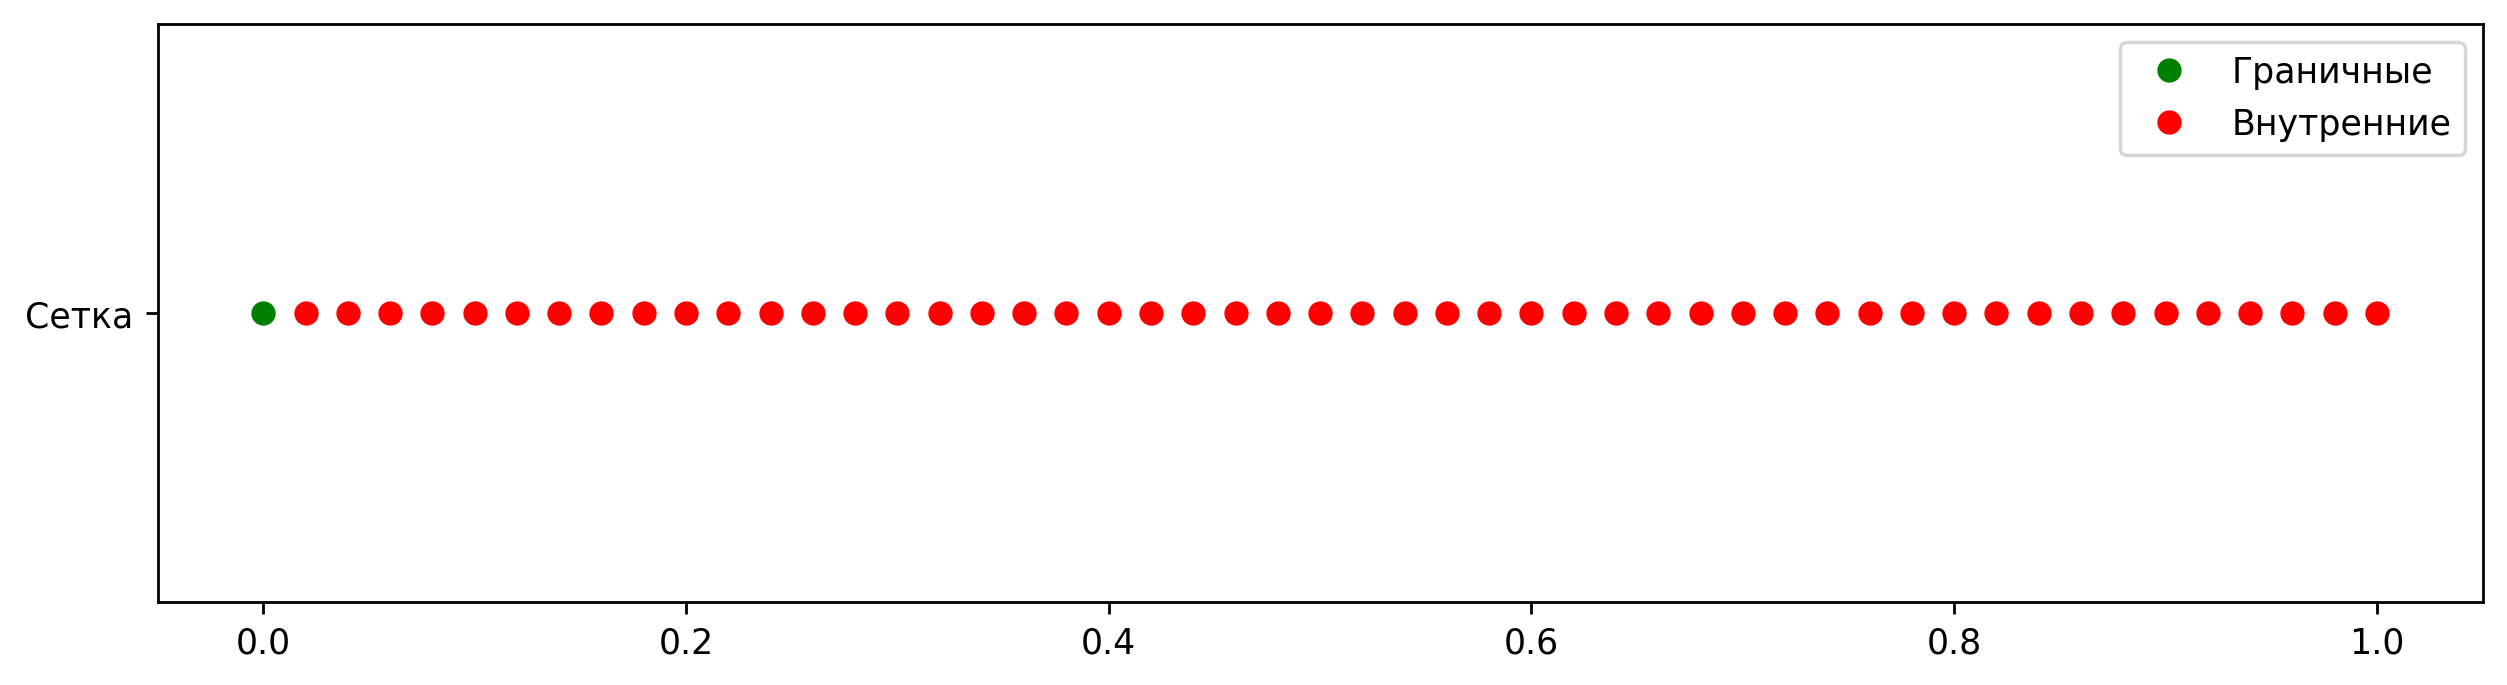

In [2]:
# Определение области определения
x_min, x_max = 0.0, 1.0

# Количество точек внутри области и на границе
num_interior = 50   # Внутренние точки
num_boundary = 1     # Граничные точки

# Генерация сетки от x_min до x_max с количеством точек num_interior+num_boundary
# view(-1, 1) - транспонирует строку в столбец
# to(device) - переводит тензор в устройство device (нужно для вычислений на GPU)
x = torch.linspace(x_min, x_max, num_interior+num_boundary).view(-1, 1).to(device)

# Создание маски для внутренних точек
# Изначально все точки помечены как False (граничные)
mask = torch.zeros_like(x, dtype = bool)

# Маркирование внутренних точек
mask[num_boundary:] = True

# Внутренние точки
# view(-1, 1) - транспонирует строку в столбец
# requires_grad_(True) - т.к. на внутренних точках нужны будут вычисления градиентов
x_interior = x[mask].view(-1, 1).requires_grad_(True)

# Граничные точки
# view(-1, 1) - транспонирует строку в столбец
x_boundary = x[~mask].view(-1, 1)

# Визуализация сетки
plt.figure(figsize=(12, 3), dpi=250)
x_boundary_plot = x_boundary.cpu().detach().numpy()
x_interior_plot = x_interior.cpu().detach().numpy()
plt.plot(x_boundary_plot, np.zeros_like(x_boundary_plot), 'o', label='Граничные', color='g')
plt.plot(x_interior_plot, np.zeros_like(x_interior_plot), 'o', label='Внутренние', color='r')
plt.yticks([0], ['Сетка'])
plt.legend()
plt.show()

In [3]:
# Определение нейронной сети
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Задаем архитектуру: 3 скрытых слоя по 20 нейронов с функцией активации Tanh
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)

# Инициализация модели
model = PINN().to(device)

In [4]:
# Определение функции потерь
def loss_function(x_interior, x_boundary, y_boundary, lambda_bc=1.0):
    # Предсказания модели на внутренних точках
    y_interior = model(x_interior)

    # Вычисление производной dy/dx с помощью автоматического дифференцирования
    dy_dx = torch.autograd.grad(
        y_interior, x_interior,
        grad_outputs=torch.ones_like(y_interior),
        create_graph=True
    )[0]

    # Вычисление функции дифференциального уравнения на внутренних точках (residual)
    residual = dy_dx - y_interior

    # Предсказания модели на граничных точках
    yb_pred = model(x_boundary)

    # Граничные условия
    y_boundary = torch.tensor([[1.0]], requires_grad=True).to(device)  # y(0) = 1

    # Потери на уравнении (MSE по residual)
    loss_interior = torch.mean(residual**2)

    # Потери на граничных условиях (MSE между предсказанием и истинным значением)
    loss_boundary = torch.mean((yb_pred - y_boundary)**2)

    # Общая функция потерь с учетом коэффициента lambda_bc
    loss = loss_interior + lambda_bc * loss_boundary
    return loss

# Определение оптимизатора (Adam с шагом обучения lr = 1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Количество эпох обучения
num_epochs = 1000

# Список для хранения значений функции потерь
loss_history = []

# Коэффициент lambda_bc для весового коэффициента граничных условий
lambda_bc = 1.0

# Цикл обучения с использованием tqdm
pbar = tqdm(range(num_epochs), desc='Training', ncols=80)
for epoch in pbar:
    optimizer.zero_grad()
    loss = loss_function(x_interior, x_boundary, lambda_bc)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    # Обновление отображения tqdm
    pbar.set_postfix({'Loss': f'{loss.item():.2e}'})

Training:   0%|                                        | 0/1000 [00:00<?, ?it/s]/home/andredon/Practice3-1/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training: 100%|█████████████| 1000/1000 [00:02<00:00, 382.68it/s, Loss=1.50e-04]


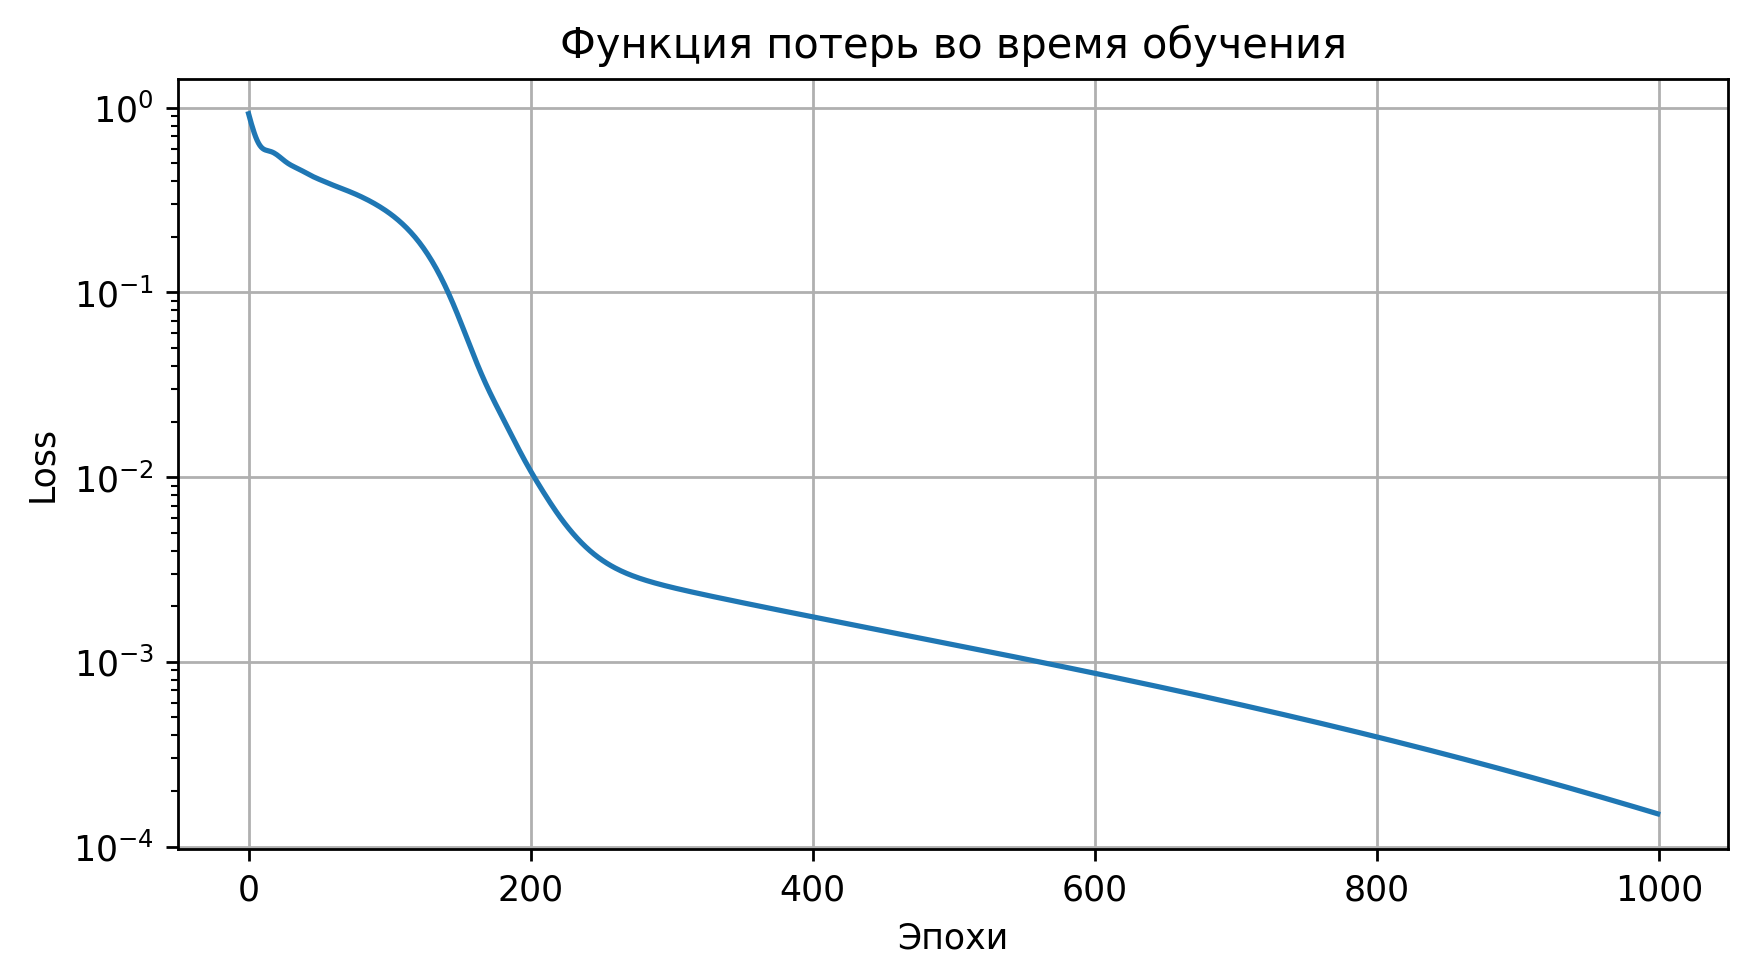

In [5]:
# Построение графика функции потерь в логарифмическом масштабе
plt.figure(figsize=(8, 4), dpi=250)
plt.plot(loss_history)
plt.yscale('log')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.title('Функция потерь во время обучения')
plt.grid(True)
plt.show()

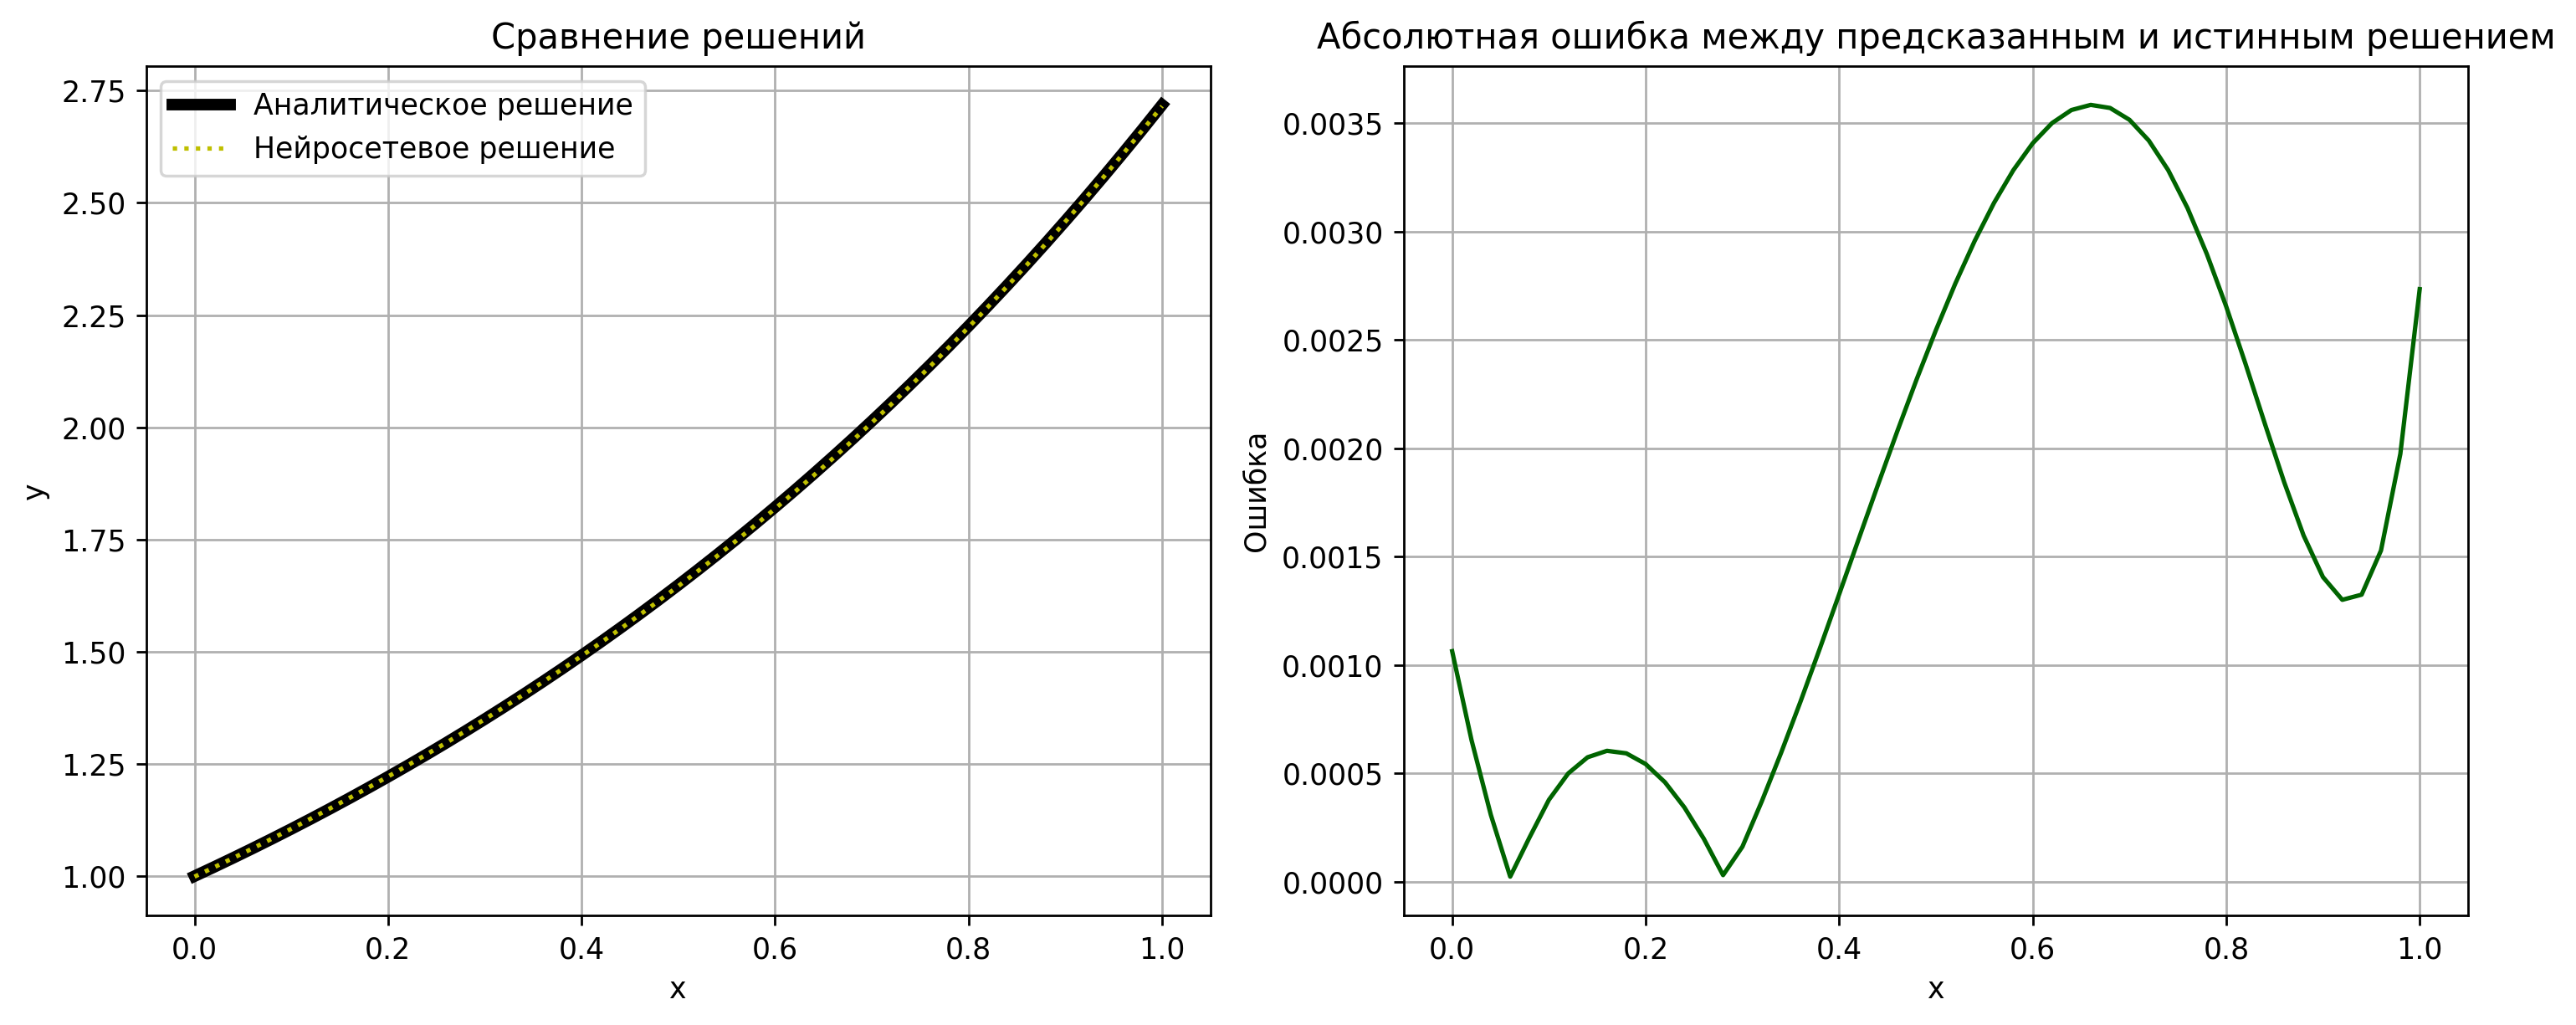

In [6]:
# Точки для визуализации решения и ошибки
x_plot = x.cpu().detach().numpy()

# Аналитическое решение
y_true = np.exp(x_plot)

# Предсказание решения моделью
y_pred = model(x).cpu().detach().numpy()

# Вычисление абсолютной ошибки
absolute_error = np.abs(y_true - y_pred)

# Построение графиков
plt.figure(figsize=(12, 5), dpi=250)

# График предсказанного и истинного решения
plt.subplot(1, 2, 1)
plt.plot(x_plot, y_true, label='Аналитическое решение', linewidth = 4, color='k')
plt.plot(x_plot, y_pred, 'y:', label='Нейросетевое решение')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Сравнение решений')
plt.legend()
plt.grid(True)

# График абсолютной ошибки
plt.subplot(1, 2, 2)
plt.plot(x_plot, absolute_error, color='darkgreen')
plt.xlabel('x')
plt.ylabel('Ошибка')
plt.title('Абсолютная ошибка между предсказанным и истинным решением')
plt.grid(True)

plt.tight_layout()
plt.show()